In [1]:
!pip install -U jupyter

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.3/14.3 MB 124.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 166.7 MB/s eta 0:00:00
  Attempting uninstall: jupyterlab
    Found existing installation: jupyterlab 4.4.2
    Uninstalling jupyterlab-4.4.2:
      Successfully uninstalled jupyterlab-4.4.2━━━━━━━━━━━━━━━━━━━ 1/4 [jupyterlab]
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4/4 [jupyter]m2/4 [notebook]b]


In [2]:
import numpy as np
import librosa
import os
import json
import matplotlib.pyplot as plt
import av
import h5py
#import seaborn as sns
import sklearn
import torch.optim as optim

from sklearn.preprocessing import StandardScaler
from collections import Counter
from collections import defaultdict
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score

In [3]:
import torch
import torchvision
import torchaudio
import torch.nn as nn

from torch.utils.data import TensorDataset, Dataset, DataLoader
from torchvision.io import read_video
from torchvision.models.video import r3d_18
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [4]:
# Check if CUDA (NVIDIA GPU) is available
gpu_available = torch.cuda.is_available()
print(f"CUDA Available: {gpu_available}")

if gpu_available:
    # Get the GPU name
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")
    
    # Get the number of GPUs
    print(f"Number of GPUs: {torch.cuda.device_count()}")
    
    # Get the current GPU memory usage
    print(f"GPU Memory Allocated: {torch.cuda.memory_allocated(0) / 1024**2:.2f} MB")
    print(f"GPU Memory Reserved: {torch.cuda.memory_reserved(0) / 1024**2:.2f} MB")
    
    # Test a simple tensor operation on GPU
    x = torch.rand(3, 3).cuda()
    print("Tensor successfully created on GPU:", x)
else:
    print("CUDA is not available. Running on CPU.")

CUDA Available: True
GPU Name: NVIDIA H100 80GB HBM3
Number of GPUs: 1
GPU Memory Allocated: 0.00 MB
GPU Memory Reserved: 0.00 MB
Tensor successfully created on GPU: tensor([[0.7428, 0.4486, 0.0019],
        [0.6485, 0.4334, 0.7109],
        [0.0078, 0.0943, 0.6890]], device='cuda:0')


In [5]:
# Set seed for reproducibility
def set_seed(seed=42):
    import random
    import torch.backends.cudnn as cudnn
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    cudnn.deterministic = True
    cudnn.benchmark = False

In [6]:
!jupyter trust classification_finetuned.ipynb

Signing notebook: classification_finetuned.ipynb


In [7]:
# l2 norm
# Load data list from JSON lines
def load_data_list(file_path='data_copy.list'):
    data_list = []
    all_keys =[]
    skipped = 0
    loaded = 0
    with open(file_path, 'r') as f:
        for line_num, line in enumerate(f, 1):
            if not line.strip():
                continue
            try:
                entry = json.loads(line.strip())
                if 'key' not in entry or 'wav_path' not in entry or 'label' not in entry:
                    print(f"Key error at line {line_num}: Missing 'key', 'wav_path', or 'label', line content: {line.strip()}")
                    skipped += 1
                    continue
                key = entry['key']
                wav_path = os.path.join('audio', os.path.basename(entry['wav_path']))
                video_path = os.path.join('video', os.path.splitext(os.path.basename(entry['wav_path']))[0] + '.avi')
                label = int(entry['label'])
                if label not in [0, 1, 2, 3]:
                    skipped += 1
                    continue
                spec_path = os.path.join('spectrograms', f'spec_{key}.npy')
                if not os.path.exists(wav_path) or not os.path.exists(video_path) or not os.path.exists(spec_path):
                    skipped += 1
                    continue
                data_list.append((wav_path, video_path, label, key))
                loaded += 1
            except json.JSONDecodeError as e:
                print(f"JSON error at line {line_num}: {e}, line content: {line.strip()}, skipping.")
                skipped += 1
                continue
            except KeyError as e:
                print(f"Key error at line {line_num}: Missing {e}, line content: {line.strip()}, skipping.")
                skipped += 1
                continue
            all_keys.append(key)
    print(f"Loaded {loaded} valid clips, skipped {skipped} entries from {file_path}.")
    return data_list, all_keys

# Normalize embeddings (L2)
def l2_normalize(X):
    return X / np.linalg.norm(X, axis=1, keepdims=True)

# Load saved audio/video embeddings

def load_embeddings(indices, data_list, embeddings_dir='features_finetuned', batch_size=16):
    X_audio, X_video, y = [], [], []
    skipped = 0
    loaded = 0
    for i in indices:
        if i >= len(data_list):
            print(f"Index {i} exceeds data_list length {len(data_list)}, skipping.")
            skipped += 1
            continue
        try:
            key = data_list[i][3]
            label = data_list[i][2]
            batch_num = i // batch_size
            audio_embed_path = os.path.join(embeddings_dir, f'batch_{batch_num}', f'audio_embed_{key}.npy')
            video_embed_path = os.path.join(embeddings_dir, f'batch_{batch_num}', f'video_embed_{key}.npy')
            if not os.path.exists(audio_embed_path) or not os.path.exists(video_embed_path):
                print(f"Missing embedding for key {key}, skipping.")
                skipped += 1
                continue
            X_audio.append(np.load(audio_embed_path))
            X_video.append(np.load(video_embed_path))
            y.append(label)
            loaded += 1
            if loaded % 5000 == 0:
                print(f"Loaded {loaded} embeddings so far.")
        except Exception as e:
            print(f"Error loading embedding for index {i}, key {data_list[i][3]}: {e}, skipping.")
            skipped += 1
            continue
    print(f"Loaded {loaded} embeddings, skipped {skipped} entries.")
    # Normalize before returning
    return l2_normalize(np.array(X_audio)), l2_normalize(np.array(X_video)), np.array(y)

# Load train/val/test indices
try:
    train_indices = np.load('train_indices.npy')
    val_indices = np.load('val_indices.npy')
    test_indices = np.load('test_indices.npy')
    print(f"Train indices: {len(train_indices)}, Val indices: {len(val_indices)}, Test indices: {len(test_indices)}")
except FileNotFoundError as e:
    print(f"Error: {e}. Ensure train_indices.npy, val_indices.npy, test_indices.npy exist.")
    raise

# Load full data list
data_list, all_keys = load_data_list('data_copy.list')

# Sanity check on indices
max_index = len(data_list) - 1
if max(train_indices) > max_index or max(val_indices) > max_index or max(test_indices) > max_index:
    print(f"Error: Indices exceed data_list length ({max_index}). Re-run split_dataset.py with data_copy.list.")
    raise ValueError("Invalid indices.")

# Load embeddings into memory
print("Loading training embeddings...")
X_train_audio, X_train_video, y_train = load_embeddings(train_indices, data_list, embeddings_dir='features_finetuned', batch_size=16)
print("Loading validation embeddings...")
X_val_audio, X_val_video, y_val = load_embeddings(val_indices, data_list, embeddings_dir='features_finetuned', batch_size=16)
print("Loading test embeddings...")
X_test_audio, X_test_video, y_test = load_embeddings(test_indices, data_list, embeddings_dir='features_finetuned', batch_size=16)

# Create TensorDatasets
train_dataset = TensorDataset(torch.tensor(X_train_audio, dtype=torch.float32),
                               torch.tensor(X_train_video, dtype=torch.float32),
                               torch.tensor(y_train, dtype=torch.long))
val_dataset = TensorDataset(torch.tensor(X_val_audio, dtype=torch.float32),
                             torch.tensor(X_val_video, dtype=torch.float32),
                             torch.tensor(y_val, dtype=torch.long))
test_dataset = TensorDataset(torch.tensor(X_test_audio, dtype=torch.float32),
                              torch.tensor(X_test_video, dtype=torch.float32),
                              torch.tensor(y_test, dtype=torch.long))

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

Train indices: 41734, Val indices: 9465, Test indices: 9277
JSON error at line 1919: Extra data: line 1 column 120 (char 119), line content: {"key": "S_M_00051_G2_task1_4_S00004", "wav_path": "data/S_M_00051_G2_task1_4_S00004.wav", "label": 1, "Frenchay": 114}4{"key": "S_M_00020_G4_task1_5_S00007", "wav_path": "data/S_M_00020_G4_task1_5_S00007.wav", "label": 1, "Frenchay": 92}, skipping.
Loaded 60476 valid clips, skipped 6712 entries from data_copy.list.
Loading training embeddings...
Loaded 5000 embeddings so far.
Loaded 10000 embeddings so far.
Loaded 15000 embeddings so far.
Loaded 20000 embeddings so far.
Loaded 25000 embeddings so far.
Loaded 30000 embeddings so far.
Loaded 35000 embeddings so far.
Loaded 40000 embeddings so far.
Loaded 41734 embeddings, skipped 0 entries.
Loading validation embeddings...
Loaded 5000 embeddings so far.
Loaded 9465 embeddings, skipped 0 entries.
Loading test embeddings...
Loaded 5000 embeddings so far.
Loaded 9277 embeddings, skipped 0 entries.


In [8]:
# Function to extract participant ID from the key
def extract_participant_id(key):
    # Split the key by underscores and take the first 3 components
    # e.g., "N_M_10010_G4_task3_4_04" -> "N_M_10010"
    parts = key.split('_')
    if len(parts) < 3:
        return None  # Invalid key format
    if 'repeat' in parts:
      participant_id = parts[1] + '_' + parts[2] + '_' + parts[3]
    else:
      participant_id = parts[0] + '_' + parts[1] + '_' + parts[2]
    return participant_id

# Function to extract participant characteristics
def get_participant_info(participant_id):
    parts = participant_id.split('_')
    if len(parts) != 3:
        return None, None
    health_status = 'Healthy' if parts[0] == 'N' else 'Patient'
    gender = 'Male' if parts[1] == 'M' else 'Female'
    return health_status, gender


# Calculate distribution, store labels, participant ID, health_status and gender
def calculate_participant_distribution(keys):
    # Dictionary to store counts of clips per participant
    participant_counts = defaultdict(int)
    # Dictionaries to store counts by health status and gender
    health_gender_counts = defaultdict(lambda: defaultdict(int))

    # list to store the participant ID
    participant_id_list = []
    # list to store the health status and genders
    health_gender_list = []


    # Group by participant
    for key in keys:
        participant_id = extract_participant_id(key)
        if participant_id is None:
            continue
        participant_id_list.append(participant_id)  #store the participant ID
        # Increment count for this participant
        participant_counts[participant_id] += 1

        # Get health status and gender
        health_status, gender = get_participant_info(participant_id)
        if health_status and gender:
            health_gender_counts[health_status][gender] += 1
        health_gender_list.append(health_status+gender)

    # Convert to lists for analysis
    participants = list(participant_counts.keys())
    counts = list(participant_counts.values())

    return participants, counts, health_gender_counts, participant_id_list, health_gender_list

# Calculate
participants, counts, health_gender_counts, participant_id_list, health_gender_list= calculate_participant_distribution(all_keys)

# classification

In [9]:
def check_embedding_scale(X_audio, X_video):
    """
    Prints basic scale statistics for audio and video embeddings.
    
    Args:
        X_audio (np.ndarray): Audio embeddings, shape [N, D]
        X_video (np.ndarray): Video embeddings, shape [N, D]
    """
    def print_stats(name, X):
        print(f"\n{name} Embeddings:")
        print(f"  Shape: {X.shape}")
        print(f"  Min: {np.min(X):.4f}")
        print(f"  Max: {np.max(X):.4f}")
        print(f"  Mean: {np.mean(X):.4f}")
        print(f"  Std: {np.std(X):.4f}")

    print_stats("Audio", X_audio)
    print_stats("Video", X_video)
check_embedding_scale(X_train_audio, X_train_video)


Audio Embeddings:
  Shape: (41734, 512)
  Min: 0.0000
  Max: 0.2346
  Mean: 0.0350
  Std: 0.0270

Video Embeddings:
  Shape: (41734, 512)
  Min: 0.0000
  Max: 0.1649
  Mean: 0.0299
  Std: 0.0325


In [10]:
# Analyze label distribution
def print_label_distribution(y, set_name):
    counter = Counter(y)
    total = len(y)
    print(f"\n{set_name} Label Distribution:")
    for label in range(4):
        count = counter.get(label, 0)
        percentage = (count / total * 100) if total > 0 else 0
        print(f"Label {label}: {count} clips ({percentage:.2f}%)")



# Get labels from loaders
def get_labels(loader):
    labels = []
    for _, _, lbls in loader:
        labels.extend(lbls.numpy())
    return np.array(labels)

print_label_distribution(get_labels(train_loader), "Training")
print_label_distribution(get_labels(val_loader), "Validation")
print_label_distribution(get_labels(test_loader), "Test")


Training Label Distribution:
Label 0: 9044 clips (21.67%)
Label 1: 19959 clips (47.82%)
Label 2: 7405 clips (17.74%)
Label 3: 5326 clips (12.76%)

Validation Label Distribution:
Label 0: 808 clips (8.54%)
Label 1: 4580 clips (48.39%)
Label 2: 2597 clips (27.44%)
Label 3: 1480 clips (15.64%)

Test Label Distribution:
Label 0: 2058 clips (22.18%)
Label 1: 4650 clips (50.12%)
Label 2: 2423 clips (26.12%)
Label 3: 146 clips (1.57%)


In [11]:
# mlp -- combined -128
class MLPFusionClassifier(nn.Module):
    def __init__(self, audio_dim=512, video_dim=512, hidden_dim=128, num_classes=4, dropout_rate=0.3):
        super(MLPFusionClassifier, self).__init__()

        # Project both modalities to hidden_dim
        self.audio_proj = nn.Linear(audio_dim, hidden_dim)
        self.video_proj = nn.Linear(video_dim, hidden_dim)

        # Classifier on [audio_128 | video_128] = (B, 256)
        self.classifier = nn.Sequential(
            nn.LayerNorm(2 * hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(2 * hidden_dim, 128),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(128, num_classes)
        )

    def forward(self, audio_embeds, video_embeds):
        a = self.audio_proj(audio_embeds)  # (B, 128)
        v = self.video_proj(video_embeds)  # (B, 128)
        x = torch.cat([a, v], dim=1)       # (B, 256)
        return self.classifier(x)          # (B, num_classes)

In [12]:
# Training function for one epoch
def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0
    for audio, video, labels in train_loader:
        audio, video, labels = audio.to(device), video.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(audio, video)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * audio.size(0)
        _, predicted = torch.max(outputs, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()
    train_loss /= train_total
    train_acc = train_correct / train_total * 100
    return train_loss, train_acc

# Validation function
def validate_epoch(model, val_loader, criterion, device):
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for audio, video, labels in val_loader:
            audio, video, labels = audio.to(device), video.to(device), labels.to(device)
            outputs = model(audio, video)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * audio.size(0)
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
    val_loss /= val_total
    val_acc = val_correct / val_total * 100
    return val_loss, val_acc

# Testing function with classification report
def test_model(model, test_loader, criterion, device):
    model.eval()
    test_loss = 0.0
    test_correct = 0
    test_total = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for audio, video, labels in test_loader:
            audio, video, labels = audio.to(device), video.to(device), labels.to(device)
            outputs = model(audio, video)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * audio.size(0)
            _, predicted = torch.max(outputs, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    test_loss /= test_total
    test_acc = test_correct / test_total * 100
    
    # Generate classification report
    print("\nTest Set Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=[f"Class {i}" for i in range(4)], digits=4))
    
    return test_loss, test_acc, all_labels, all_preds

# Training loop function
def train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=30, best_model_path='classifier.pth'):
    best_val_acc = 0.0
    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []
    
    for epoch in range(num_epochs):
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
        val_loss, val_acc = validate_epoch(model, val_loader, criterion, device)
        
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
        
        # Step the scheduler
        scheduler.step(val_loss)
        
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), best_model_path)
            print(f"Saved best model with Val Acc: {best_val_acc:.2f}%")
    
    return train_losses, train_accs, val_losses, val_accs



Training model...
Epoch 1/30, Train Loss: 0.0450, Train Acc: 99.40%, Val Loss: 2.6770, Val Acc: 47.93%
Saved best model with Val Acc: 47.93%
Epoch 2/30, Train Loss: 0.0004, Train Acc: 100.00%, Val Loss: 3.0014, Val Acc: 48.28%
Saved best model with Val Acc: 48.28%
Epoch 3/30, Train Loss: 0.0002, Train Acc: 100.00%, Val Loss: 3.2910, Val Acc: 48.54%
Saved best model with Val Acc: 48.54%
Epoch 4/30, Train Loss: 0.0001, Train Acc: 100.00%, Val Loss: 3.3837, Val Acc: 48.57%
Saved best model with Val Acc: 48.57%
Epoch 5/30, Train Loss: 0.0001, Train Acc: 100.00%, Val Loss: 3.4083, Val Acc: 49.24%
Saved best model with Val Acc: 49.24%
Epoch 6/30, Train Loss: 0.0001, Train Acc: 100.00%, Val Loss: 3.5271, Val Acc: 48.37%
Epoch 7/30, Train Loss: 0.0001, Train Acc: 100.00%, Val Loss: 3.7289, Val Acc: 48.68%
Epoch 8/30, Train Loss: 0.0001, Train Acc: 100.00%, Val Loss: 3.7168, Val Acc: 49.05%
Epoch 9/30, Train Loss: 0.0001, Train Acc: 100.00%, Val Loss: 4.0657, Val Acc: 48.57%
Epoch 10/30, Train 

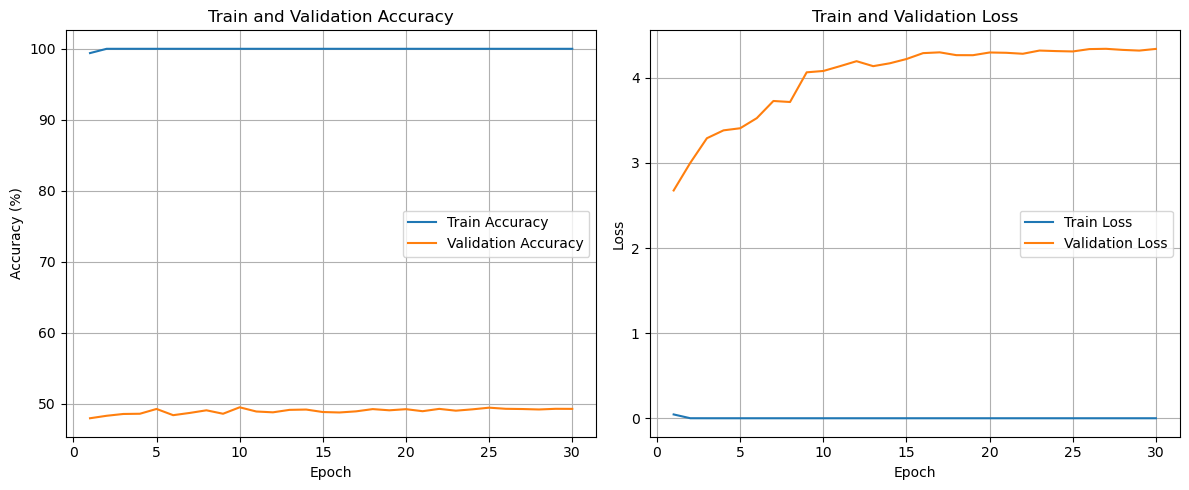

Saved training metrics plot as 'training_metrics.png'


In [13]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Compute weights inversely proportional to class frequency
def get_class_weights(y, num_classes=4):

    counts = Counter(y)
    total = sum(counts.values())
    weights = [total / counts.get(i, 1) for i in range(num_classes)]
    weights = torch.tensor(weights, dtype=torch.float32)
    return weights / weights.sum()
# Usage
class_weights = get_class_weights(y_train, num_classes=4).to(device)
# Initialize model, loss, and optimizer

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
#model = SelfAttentionClassifier().to(device)
#model = CrossAttentionClassifier().to(device)
model = MLPFusionClassifier().to(device)
#model = MultiHeadFusionClassifier().to(device)
#model = LinearFusionClassifier().to(device)
criterion = nn.CrossEntropyLoss(weight = class_weights)  #  class weights (imbalanced)
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=3
)
# Train model
print("Training model...")
train_losses, train_accs, val_losses, val_accs = train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=30)

# Load best model and test
model.load_state_dict(torch.load('classifier.pth'))
test_loss, test_acc, all_labels, all_preds = test_model(model, test_loader, criterion, device)
print(f"\nTest Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%")

# Plot training and validation metrics
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_accs) + 1), train_accs, label='Train Accuracy')
plt.plot(range(1, len(val_accs) + 1), val_accs, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Train and Validation Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Validation Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('training_metrics.png')
plt.show()
print("Saved training metrics plot as 'training_metrics.png'")

In [14]:
test_participants = np.array(participant_id_list)[test_indices] #get the participant info for all test clips
def compute_score(test_preds,test_labels,test_participant_list=test_participants):

    # Compute F1-score for all segments (standard classification F1-score)
    F1_segment = f1_score(test_labels, test_preds, average='macro')
    print(f"F1 Score (Segment): {F1_segment:.4f}")

    
    #Compute individual f1 score 
    # Convert lists to NumPy arrays for easier manipulation
    all_preds = np.array(test_preds)
    all_labels = np.array(test_labels)

    test_participant_np = np.array(test_participant_list)
    
    # Get unique participants
    unique_test_participant = np.unique(test_participant_np)
    
    f1_individual_scores = []
    
    # Compute F1-score for each participant
    for participant in unique_test_participant:
        indices = np.where(test_participant_np == participant)[0]  # Ensure valid indices
        if len(indices) == 0:  # Skip if no samples found
            continue  

        participant_preds = all_preds[indices]
        participant_labels = all_labels[indices]
    
        f1_individual = f1_score(participant_labels, participant_preds, average='macro')
        f1_individual_scores.append(f1_individual)
    
    # Compute overall F1-score for individuals
    F1_individual = np.mean(f1_individual_scores)
    print(f"F1 Score (Individual): {F1_individual:.4f}")


    # Final Ranking Score
    final_score = (F1_individual * 10) + F1_segment
    print(f"Final Evaluation Score: {final_score:.4f}")

    # Print classification report
    print("\nClassification Report:")
    print(classification_report(test_labels, test_preds))
compute_score(all_preds,all_labels)

F1 Score (Segment): 0.5305
F1 Score (Individual): 0.6015
Final Evaluation Score: 6.5456

Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.98      0.83      2058
           1       0.60      0.71      0.65      4650
           2       0.39      0.10      0.16      2423
           3       0.33      0.82      0.47       146

    accuracy                           0.61      9277
   macro avg       0.51      0.65      0.53      9277
weighted avg       0.57      0.61      0.56      9277



In [15]:
def analyze_clipwise_errors(test_preds, test_labels, test_participant_list, test_indices):
    # Convert everything to NumPy arrays
    preds = np.array(test_preds)
    labels = np.array(test_labels)
    participants = np.array(test_participant_list)
    indices = np.array(test_indices)

    # Build DataFrame to track each prediction
    df = pd.DataFrame({
        'dataset_index': indices,
        'participant': participants,
        'true_label': labels,
        'predicted_label': preds,
    })

    # Mark whether each prediction is correct
    df['correct'] = df['true_label'] == df['predicted_label']

    # Print summary
    print(f"\nCorrect predictions: {df['correct'].sum()} / {len(df)}")
    print(f"Incorrect predictions: {len(df) - df['correct'].sum()}")

    # Optional: Confusion counts
    print("\nTop mistakes (True → Predicted):")
    confusion_counts = df[~df['correct']].groupby(['true_label', 'predicted_label']).size().sort_values(ascending=False)
    print(confusion_counts.head(10))

    return df

In [21]:
import pandas as pd

In [22]:
# Load your saved test indices
test_indices = np.load('test_indices.npy')

# Analyze
results_df = analyze_clipwise_errors(all_preds, all_labels, test_participants, test_indices)


Correct predictions: 5697 / 9277
Incorrect predictions: 3580

Top mistakes (True → Predicted):
true_label  predicted_label
2           1                  2171
1           0                   742
            2                   369
            3                   232
0           2                    26
3           0                    16
0           3                    12
3           1                    10
0           1                     2
dtype: int64


In [30]:
!pip install seaborn

In [31]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import seaborn as sns

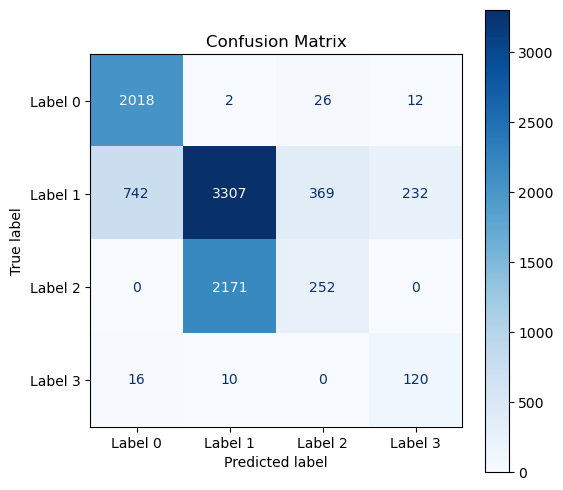

In [24]:
# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)
labels = ['Label 0', 'Label 1', 'Label 2', 'Label 3']  # or use dysarthria type names if you have them

# Display it nicely
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
fig, ax = plt.subplots(figsize=(6, 6))  # Adjust size as needed
disp.plot(cmap=plt.cm.Blues, ax=ax, values_format='d')  # or '.2f' for percentages
plt.title("Confusion Matrix")
plt.show()

In [27]:
# Convert to binary: class 0 vs. others (1, 2, 3)
def convert_to_binary(y, positive_class=0):
    return [1 if label == positive_class else 0 for label in y]

binary_preds = convert_to_binary(all_preds, positive_class=0)
binary_labels = convert_to_binary(all_labels, positive_class=0)

# Generate classification report
print("Binary Classification Report (Class 0 vs. Rest):")
print(classification_report(binary_labels, binary_preds, target_names=["Rest (1/2/3)", "Class 0"]))

# Optional: Confusion matrix
cm2 = confusion_matrix(binary_labels, binary_preds)
print("Confusion Matrix:")
print(cm2)

Binary Classification Report (Class 0 vs. Rest):
              precision    recall  f1-score   support

Rest (1/2/3)       0.99      0.89      0.94      7219
     Class 0       0.73      0.98      0.83      2058

    accuracy                           0.91      9277
   macro avg       0.86      0.94      0.89      9277
weighted avg       0.93      0.91      0.92      9277

Confusion Matrix:
[[6461  758]
 [  40 2018]]


Binary Classification Report (Class 0 vs. Rest):
              precision    recall  f1-score   support

Rest (1/2/3)       0.99      0.89      0.94      7219
     Class 0       0.73      0.98      0.83      2058

    accuracy                           0.91      9277
   macro avg       0.86      0.94      0.89      9277
weighted avg       0.93      0.91      0.92      9277



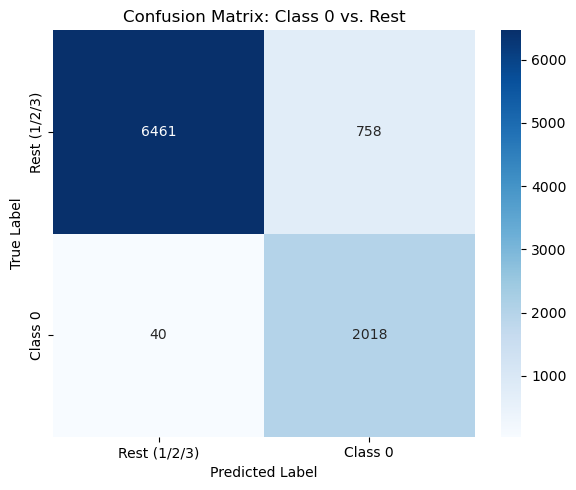

In [32]:


# Convert to binary: class 0 vs. others
def convert_to_binary(y, positive_class=0):
    return [1 if label == positive_class else 0 for label in y]

binary_preds = convert_to_binary(all_preds, positive_class=0)
binary_labels = convert_to_binary(all_labels, positive_class=0)

# Generate classification report
print("Binary Classification Report (Class 0 vs. Rest):")
print(classification_report(binary_labels, binary_preds, target_names=["Rest (1/2/3)", "Class 0"]))

# Confusion matrix
cm2 = confusion_matrix(binary_labels, binary_preds)
labels = ["Rest (1/2/3)", "Class 0"]

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm2, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix: Class 0 vs. Rest")
plt.tight_layout()
plt.show()